# Using Clustering to Redefine NBA Player Roles
The goal of this notebook is to use a large set of player statistics to redefine the roles that NBA players serve on a team.  Traditionally, players are classified as one of five positions, Point Guard, Shooting Guard, Small Forward, Power Forward and Center.  While these positions still have some meaning in today's NBA, players are often described based on their skillset and role on the team.

This analysis will try to cluster players based on their statistics, and use it to generate new positions that are based on how a player contributes to the team.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


# Prepare Datasets for Analysis
Import the datasets 'Players.csv' and 'Seasons_Stats.csv'. Players contains information about each of the players in the NBA since 1950, while stats is a multidimensional dataset containing individual player statistics, both regular and advanced, for the same set of players.

In [3]:
players = pd.read_csv('Players.csv', index_col=0)
stats = pd.read_csv('Seasons_Stats.csv', index_col=0)
print(players.head())
print(stats.head())

            Player  height  weight                          collage    born  \
0  Curly Armstrong   180.0    77.0               Indiana University  1918.0   
1     Cliff Barker   188.0    83.0           University of Kentucky  1921.0   
2    Leo Barnhorst   193.0    86.0         University of Notre Dame  1924.0   
3       Ed Bartels   196.0    88.0  North Carolina State University  1925.0   
4      Ralph Beard   178.0    79.0           University of Kentucky  1927.0   

    birth_city birth_state  
0          NaN         NaN  
1     Yorktown     Indiana  
2          NaN         NaN  
3          NaN         NaN  
4  Hardinsburg    Kentucky  
     Year           Player  Pos   Age   Tm     G  GS  MP  PER    TS%  ...    \
0  1950.0  Curly Armstrong  G-F  31.0  FTW  63.0 NaN NaN  NaN  0.368  ...     
1  1950.0     Cliff Barker   SG  29.0  INO  49.0 NaN NaN  NaN  0.435  ...     
2  1950.0    Leo Barnhorst   SF  25.0  CHS  67.0 NaN NaN  NaN  0.394  ...     
3  1950.0       Ed Bartels    F  24

First, we will drop the blank columns from the dataframe.  Next, we will merge the two datasets in order to include height and weight in our analysis along with game statistics.  We will then filter out players that played less than 1200 minutes, to include only players that made substantial impacts on their teams, and limit our stats to the 2017 season.

Focusing on the statistics, we will drop all total stats because they will account for much of the variance and separate players by their total production rather than play style.  Next will be the redundant statistics.  Box Plus Minus (BPM) is a combination of Offensive BPM and Defensive BPM, so including BPM is redundant.  We will similarly remove TRB%, eFG%, and TS%.

In [33]:
stats.drop(['blanl','blank2'],axis=1)
stats_players = pd.merge(players[['Player','height','weight']],stats,on='Player').fillna(0)
qual_players = stats_players[stats_players.MP > 1200]
modern_stats = qual_players[qual_players.Year > 2016]
modern_stats.height = modern_stats.height.apply(lambda x: x* 0.3937)
modern_stats = modern_stats[modern_stats.Pos.isin(['PG','SG','SF','PF','C'])]
modern_stats = modern_stats.drop(['blanl','blank2','WS','WS/48','Pos','Year','Tm','GS','G','PER','OWS','DWS','MP','Age','ORB','DRB','TRB','AST','STL','BLK','TOV','PTS','FG','FGA','3P','3PA','2P','2PA','FT','FTA','VORP','TRB%','TS%','PF','BPM','eFG%','FG%','OBPM','DBPM'], axis=1)
print(modern_stats.head())

                 Player   height  weight   3PAr    FTr  ORB%  DRB%  AST%  \
7440   Gerald Henderson  74.0156    79.0  0.313  0.298   2.2  10.0  10.5   
8344        Larry Nance  81.8896    92.0  0.100  0.222   8.8  19.6   9.7   
12116      Tim Hardaway  72.0471    79.0  0.457  0.235   1.8   9.5  14.3   
14916    Glenn Robinson  79.1337   102.0  0.370  0.225   4.5  14.6   4.7   
16716      Vince Carter  77.9526    99.0  0.604  0.235   2.2  12.5  11.5   

       STL%  BLK%  TOV%  USG%    3P%    2P%    FT%  
7440    1.2   0.7   9.0  17.9  0.353  0.455  0.806  
8344    2.8   2.3  12.4  13.4  0.278  0.554  0.738  
12116   1.3   0.6   9.5  22.5  0.357  0.537  0.766  
14916   1.4   1.2   9.1  12.8  0.392  0.512  0.711  
16716   1.7   1.9   8.5  14.9  0.378  0.418  0.765  


C:\Python34\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


# Dimensionality Reduction
Even though the dataset has been whittled down to include only the statistics we are interested in, we now have a multidimensional dataset.  Principal Component Analysis (PCA) will be used to reduce the dataset to fewer dimensions that account for a large amount of variance in the data.

0.782070904242
[[  2.66348779e-02  -2.74821864e-01   2.12518006e-03   1.65322741e-03
   -1.28822127e-01  -1.64443581e-01   8.66659340e-01   2.08125743e-02
   -4.20632231e-02   1.69179324e-01   3.13309369e-01   3.34136723e-03
   -2.08073373e-04   4.78979944e-03]
 [ -5.37531263e-01   1.71657303e-01  -1.97307230e-02   6.61676830e-03
    3.39738173e-01   7.05323663e-01   2.04604109e-01  -1.07749896e-02
    8.67358631e-02   4.63232711e-02   1.27919074e-01  -1.06729138e-02
   -1.88358899e-03  -1.13440137e-02]]


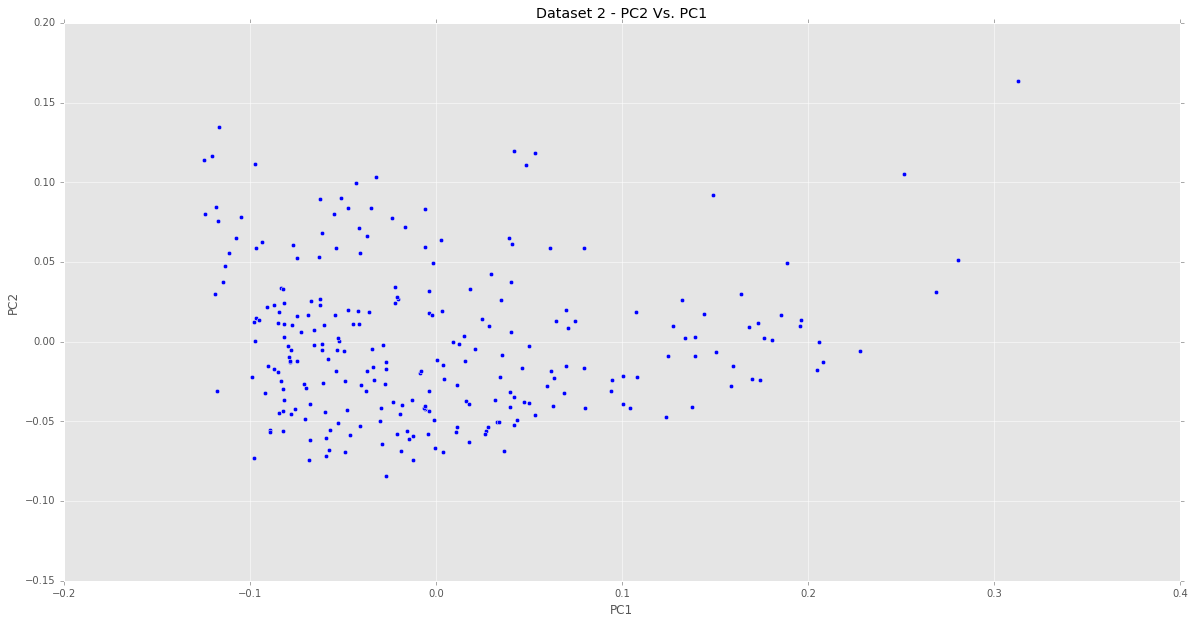

In [34]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalize(modern_stats.iloc[:,1:]))
print(sum(pca.explained_variance_ratio_))
print(pca.components_)
plt.figure(figsize=(20,10))
plt.title('Dataset 2 - PC2 Vs. PC1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(reduced_data[:,0], reduced_data[:,1],cmap = 'viridis')
plt.show()

# Choosing the Number of Clusters
Once the dataset has been reduced to two dimensions, we will perform a silhouette analysis to decide how many clusters is the right amount.  Since there are five traditional positions, we will perform the analysis for the range of 5-13 clusters.

For n_clusters = 5 The average silhouette_score is : 0.406004149336


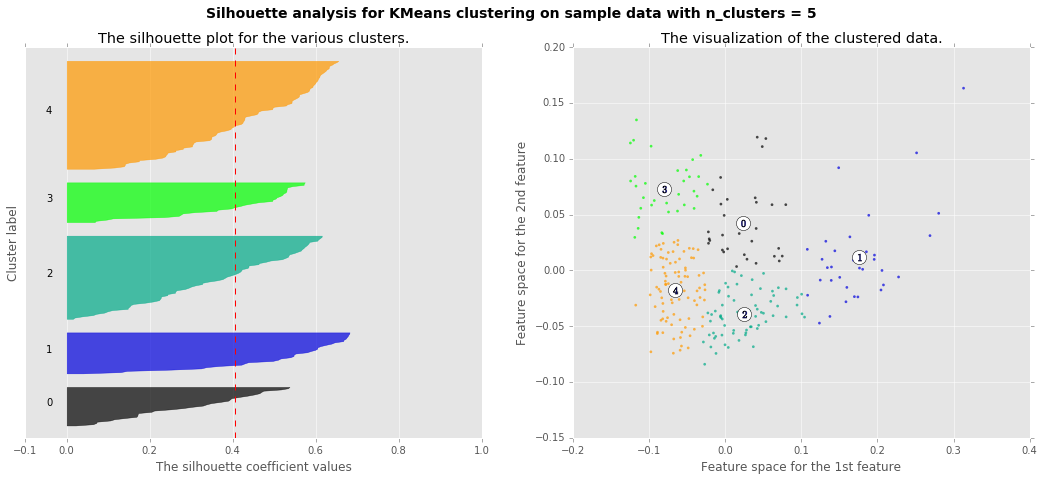

For n_clusters = 6 The average silhouette_score is : 0.381706579484


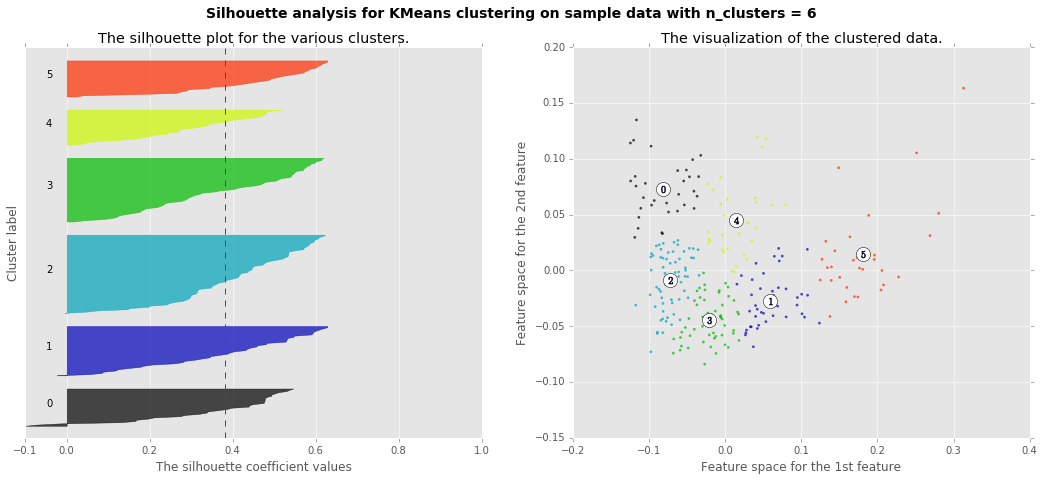

For n_clusters = 7 The average silhouette_score is : 0.382509075256


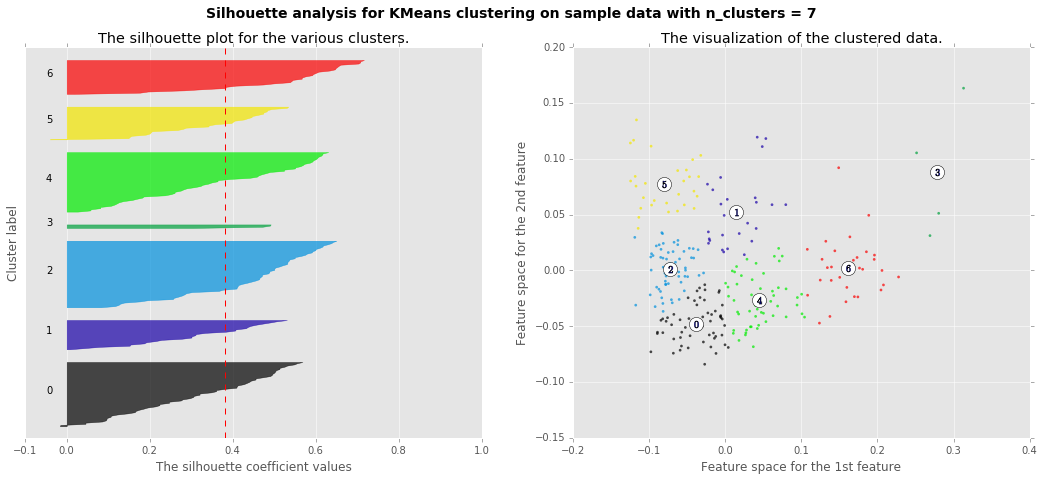

For n_clusters = 8 The average silhouette_score is : 0.370070452141


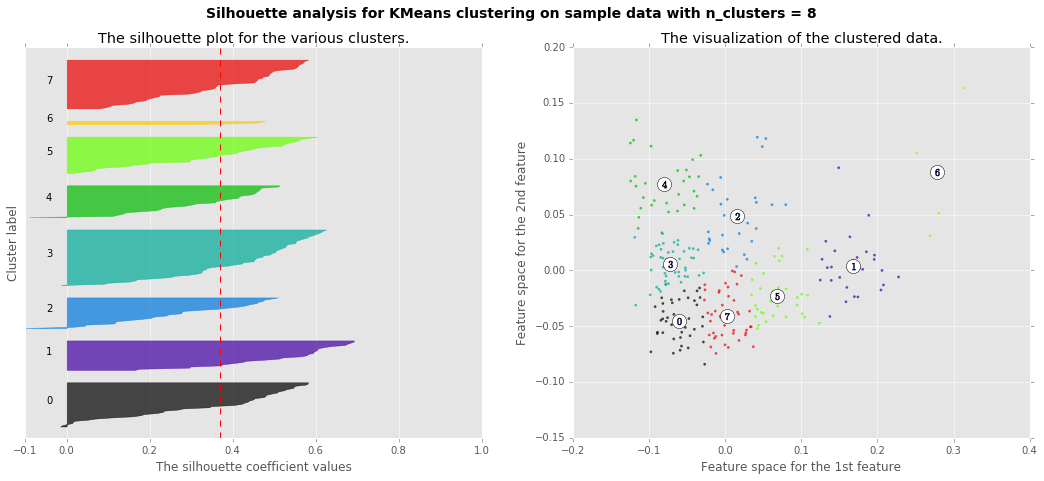

For n_clusters = 9 The average silhouette_score is : 0.380152841742


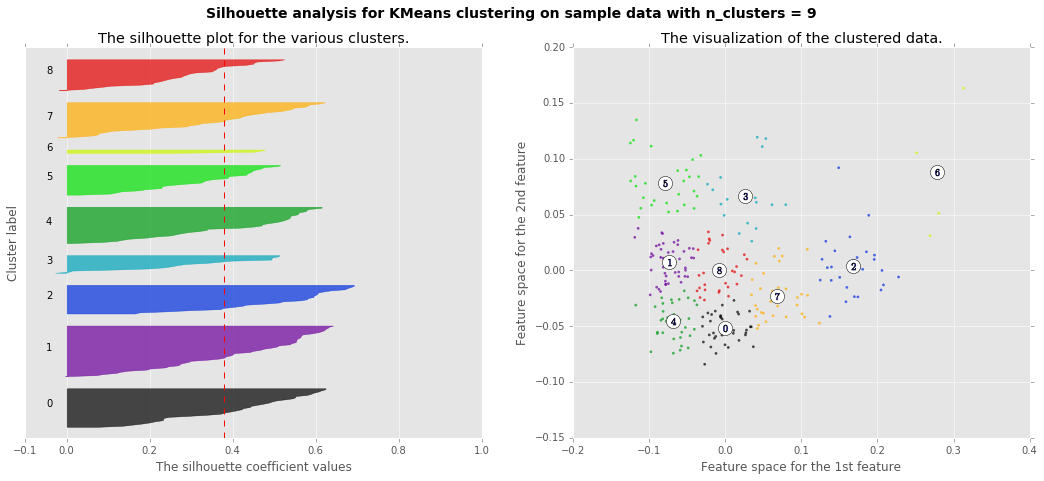

For n_clusters = 10 The average silhouette_score is : 0.400645166577


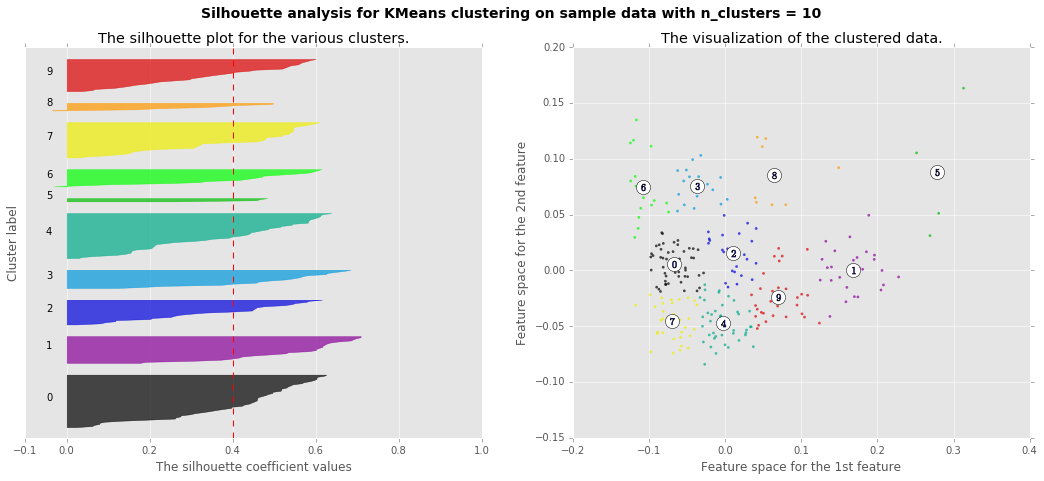

For n_clusters = 11 The average silhouette_score is : 0.397956373596


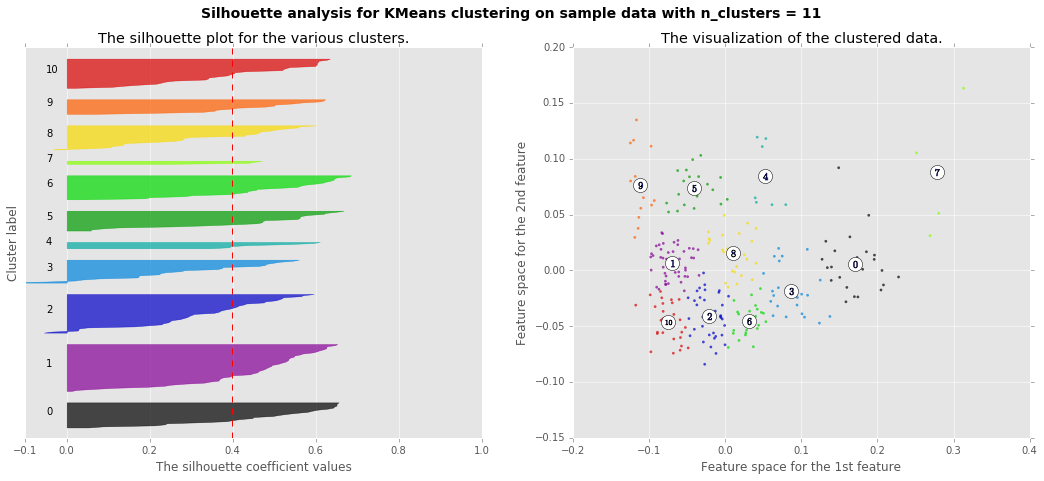

For n_clusters = 12 The average silhouette_score is : 0.368319627213


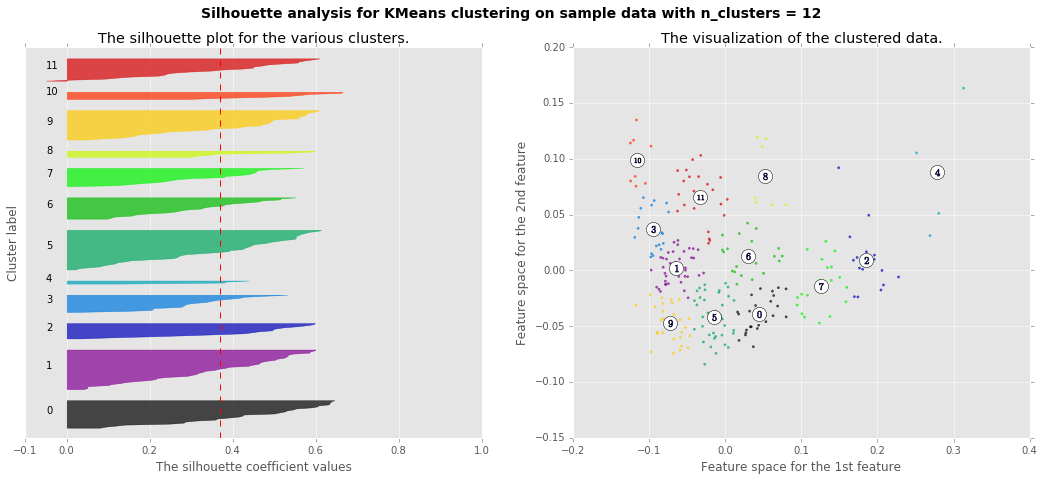

For n_clusters = 13 The average silhouette_score is : 0.374860349259


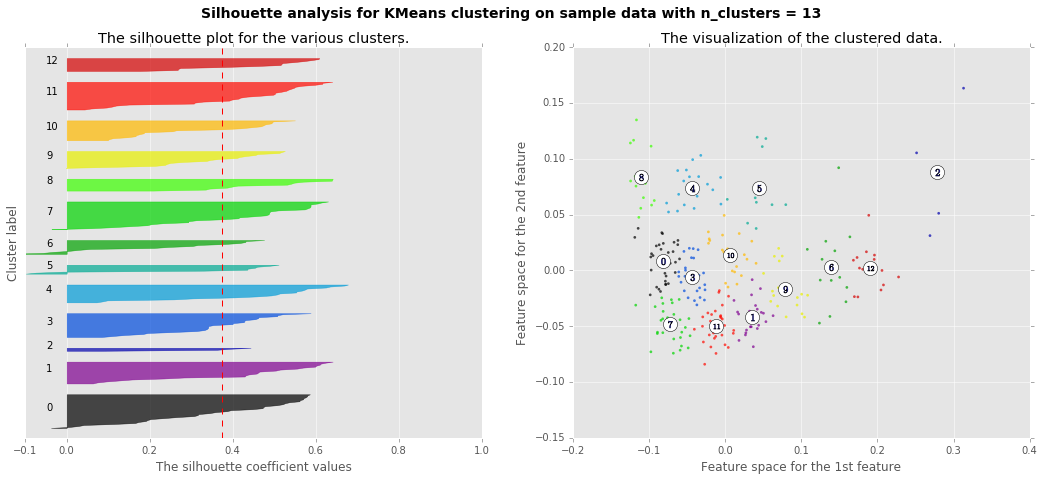

In [35]:
range_n_clusters = [5, 6, 7, 8, 9, 10, 11, 12,13]
X = reduced_data

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

Comparing the silhouette scores, which correspond to the separation distance between clusters.  An average score close to +1 means that on average, samples in one cluster are far from neighboring clusters.  For n=10 clusters, we have an average silhouette score of 0.40.  In addition, with the exception of clusters 5 and 8, the cluster sizes are somewhat close.

In [36]:
clusterer = KMeans(n_clusters=10, random_state=10)
cluster_labels = clusterer.fit_predict(X)
num_clusters = len(set(cluster_labels))

Using Scikit-Learn's KMeans clustering method, we will assign each player a cluster.  We then plot each cluster with player names as labels for each point.

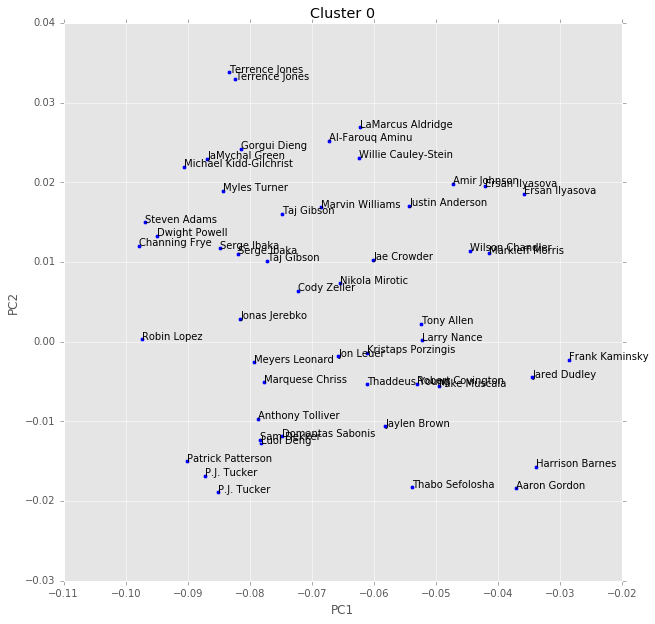

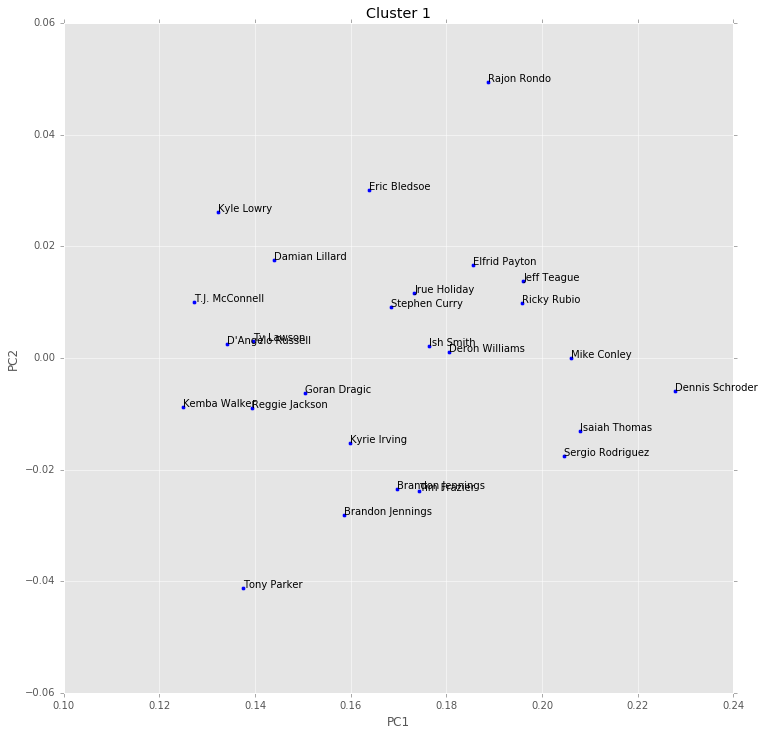

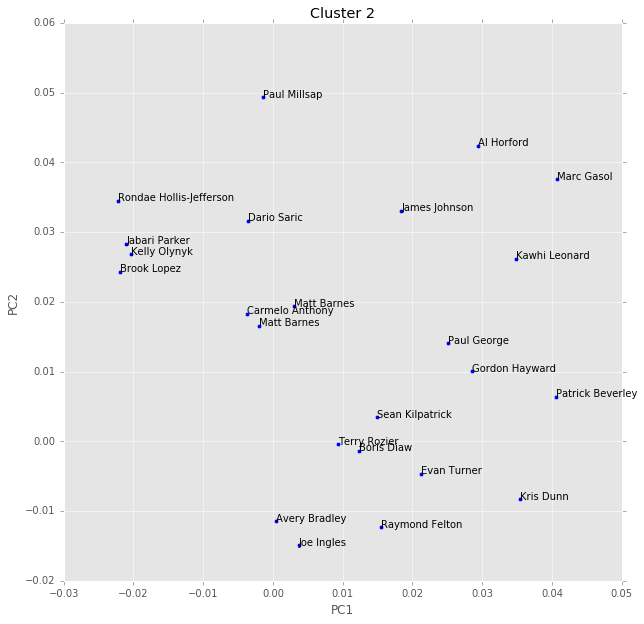

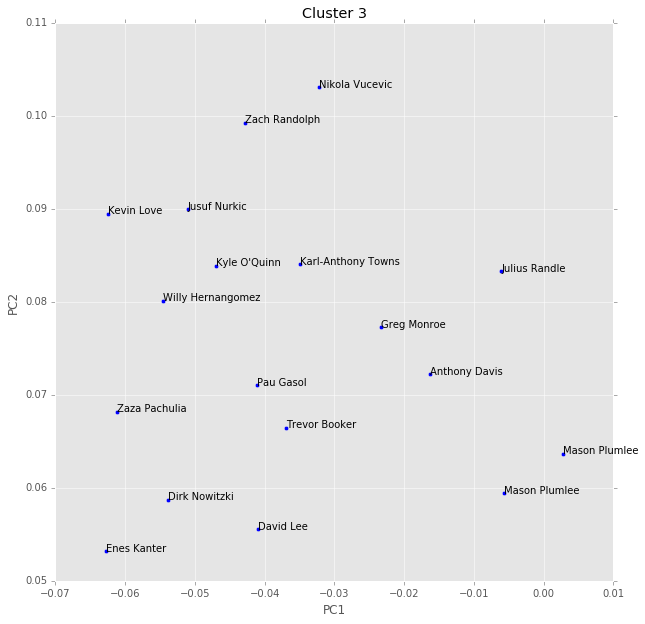

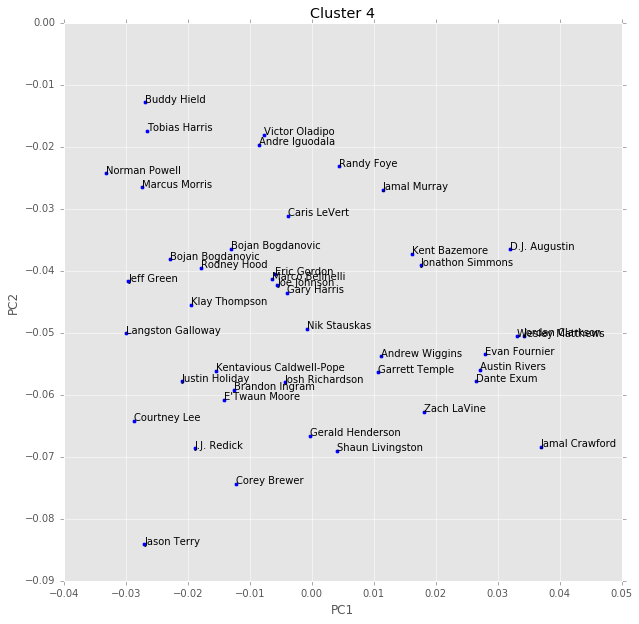

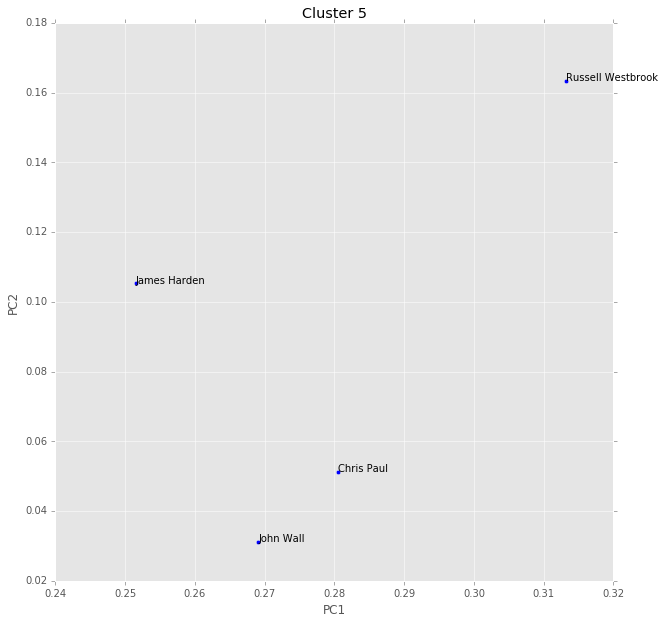

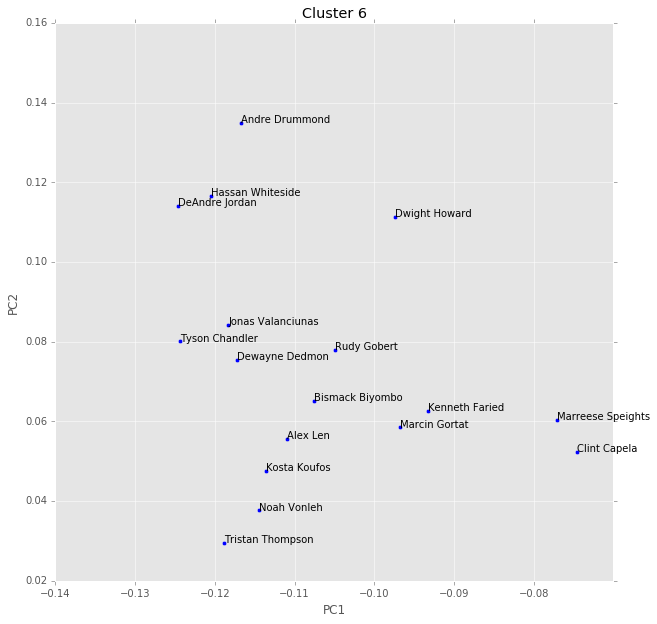

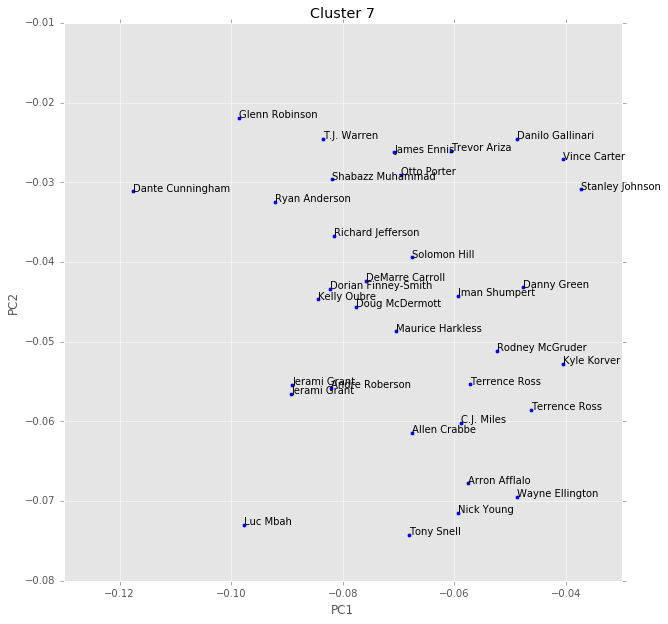

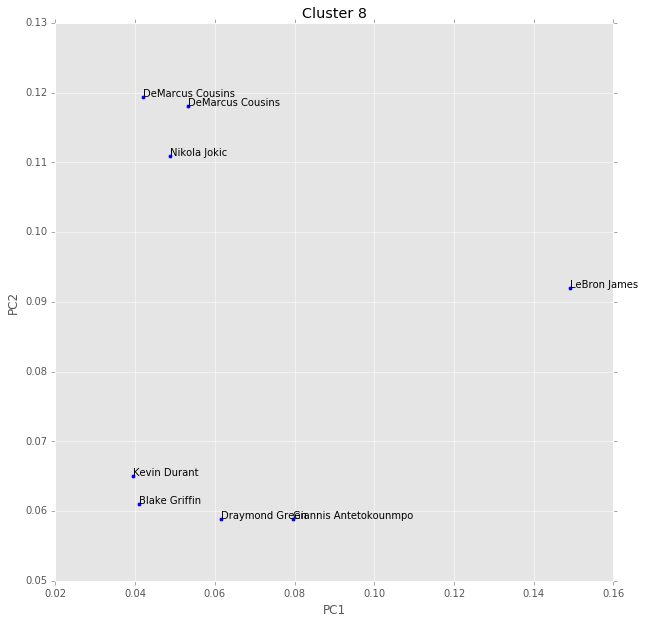

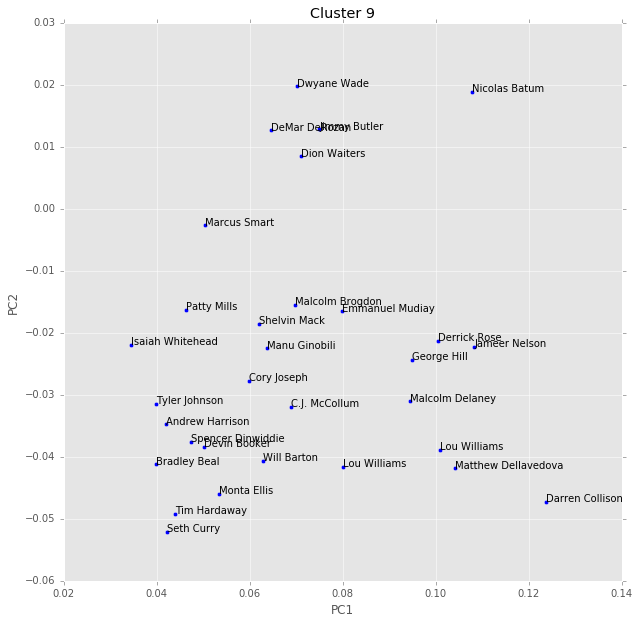

In [37]:
plt.figure(figsize=(12,12))
ms2 = modern_stats
ms2['Cluster'] = cluster_labels

for ii in range(num_clusters):
    plt.figure(ii, figsize=(10,10))
    plt.title('Cluster ' + str(ii))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    for i in range(len(cluster_labels)):
        if cluster_labels[i] == ii:
            plt.scatter(X[i,0],X[i,1])
            plt.annotate(modern_stats.Player.iloc[i],xy=(X[i,0],X[i,1]),xycoords='data')

plt.show()

Cluster 0:  Stretch Bigs - Bigger Size, Average 3PAr, Below average 2P% implies less baskets around the rim
Cluster 1:  Ball Dominant Guards - High Usage Rate, High AST%, High TOV%
Cluster 2:  3 and D Wings - Above average 3PAr, high DBPM
Cluster 3:  Scoring Big -  Big Size, High Usage, High ORB%, DRB%
Cluster 4:  Scoring Guard - Slightly Above Average Usage, with a slightly below average AST%
Cluster 5:  Elite Ball Dominant Guard (Westbrook, Harden, Wall, Paul) - Significantly High AST%, USG%, OBPM, High DBPM
Cluster 6:  Defensive Bigs - Biggest Size, High BLK%, 2P%, DRB%, ORB%, Near Zero 3PAr
Cluster 7:  3 Point Shooting Wings - High 3PAr, Low FTr, Low Usage
Cluster 8:  Versatile Bigs (Point Forwards) - Bigger Size, High AST%, ORB%, DRB%, Usage, BLK%
Cluster 9:  Combo Guard - Above Average 3PAr, AST%, Usage
 

Looking at the results, we have 10 clusters corresponding to different positions that are described above.

Some observations that jump out:

While Ball-Dominant guards are one of the new positions, John Wall, Russell Westbrook, James Harden, and Chris Paul are in their own league in terms of overall play as a scorer and distributor.  For even smaller numbers of clusters, the model groups them in a separate category of ball-dominant guard.

Another "Elite Cluster" is the Versatile Bigs or Point Forwards category.  This category contains Lebron James, Kevin Durant, Giannis Antetokounmpo, Draymond Green, Demarcus Cousins, Blake Griffin, and Nikola Jokic.  These players distinguish themselves from the nearest clusters of Ball-Dominant Guards, Scoring Bigs, and 3 and D wings.  Between this cluster and the Elite Ball Dominant Guards, the majority of the MVP candidates are covered.

# Examining the Makeup of Finals Teams
Now that we have redefined the positions in the NBA, lets look at how the two teams in the NBA finals were constructed.  These are the lineups with the highest net ratings for the Warriors and the Cavaliers:

Warriors - Stephen Curry (Ball Dominant Guard), Klay Thompson (Scoring Guard), Kevin Durant (Versatile Big), Draymond Green (Versatile Big), Andre Iguodala (Scoring Guard)

Cavaliers - Kyrie Irving (Ball Dominant Guard), Lebron James (Versatile Big), Kevin Love (Scoring Big), JR Smith(3 and D wing), Tristan Thompson (Defensive Big)

The two teams are constructed differently, with the most notable difference being that the Cavs use a defensive big in Tristan Thompson.  The Warriors don't use any defensive bigs, likely because they are offered some flexibility having two versatile bigs in Draymond Green and Kevin Durant.  However, both teams still use a ball dominant guard.